# Предсказание температуры расплава стали
<img src = 'https://cdn.dribbble.com/users/224485/screenshots/1953078/factory_1.gif'>

## Задача

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание входных данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## План работы

1. Подготовка и первый взгляд на данные
    * 1.1 Данные об электродах
    * 1.2 Данные о подаче сыпучих материалов (объём)
    * 1.3 Данные о подаче сыпучих материалов (время)
    * 1.4 Данные о продувке сплава газом
    * 1.5 Результаты измерения температуры
    * 1.6 Данные о проволочных материалах (объём)
    * 1.7 Данные о проволочных материалах (время)
    * Промежуточный вывод
2. Подготовка фрейма для обучения
    * Промежуточный вывод
3. Обучение моделей
4. Вывод

***

## 1. Подготовка и первый взгляд на данные

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from tqdm import trange

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter('ignore')

RND = 12092022

In [2]:
table_names = {
    'df_arc': 'data_arc.csv',
    'df_bulk': 'data_bulk.csv',
    'df_bulk_time': 'data_bulk_time.csv',
    'df_gas': 'data_gas.csv',
    'df_temp': 'data_temp.csv',
    'df_wire': 'data_wire.csv',
    'df_wire_time': 'data_wire_time.csv',
}
pth1 = '/datasets/final_steel/'
pth2 = './data/'


if os.path.exists(pth1 + table_names['df_arc']):
    all_data = {
        'df_arc': pd.read_csv(pth1 + table_names['df_arc']),
        'df_bulk': pd.read_csv(pth1 + table_names['df_bulk']),
        'df_bulk_time': pd.read_csv(pth1 + table_names['df_bulk_time']),
        'df_gas': pd.read_csv(pth1 + table_names['df_gas']),
        'df_temp': pd.read_csv(pth1 + table_names['df_temp']),
        'df_wire': pd.read_csv(pth1 + table_names['df_wire']),
        'df_wire_time': pd.read_csv(pth1 + table_names['df_wire_time']),
    }
elif os.path.exists(pth2 + table_names['df_arc']):
    all_data = {
        'df_arc': pd.read_csv(pth2 + table_names['df_arc']),
        'df_bulk': pd.read_csv(pth2 + table_names['df_bulk']),
        'df_bulk_time': pd.read_csv(pth2 + table_names['df_bulk_time']),
        'df_gas': pd.read_csv(pth2 + table_names['df_gas']),
        'df_temp': pd.read_csv(pth2 + table_names['df_temp']),
        'df_wire': pd.read_csv(pth2 + table_names['df_wire']),
        'df_wire_time': pd.read_csv(pth2 + table_names['df_wire_time']),
    }
else:
    print('Something is wrong')

In [3]:
def label(name):
    """
    Формат этикетки:
        -----------------
        #   Имя_Ключа   #
        -----------------
    """
    name_string = f"#   {name}   #"
    res = (""+ "-" * len(name_string)+"\n"+ (name_string)+ "\n"+ "-" * len(name_string) + '\n')
    return res

In [4]:
def show_na(df):
    """ Ф-ция подсчета пропусков и нулевых значений """
    na_info = (df.isna() | df.isnull()).sum()
    result = (pd.concat([na_info / df.shape[0], na_info], axis=1,  keys=['percent', 'abs'])
              .sort_values('percent', ascending=False))
    
    return result

In [5]:
def first_check(df):
    """ Ф-ция first look на фрейм """
    print(label(df))
    print(f"Первые 5 строк: \n {all_data[df].head()} \n {'-'*100} \n" + "Cуммарная информация:")
    print(f"\n {all_data[df].info()} \n {'-'*100} \n" + "Сводка:")
    print(f"\n {all_data[df].describe()} \n {'-'*100} \n")
    print(f"Пропуски: \n {show_na(all_data[df])}")

In [6]:
def graph(name,predict):
    """ Ф-ция построения графика распределения зависимости """
    plt.figure(figsize=(8,8))
    sns.regplot(x=t_test, y=predict)
    plt.title('График распределения зависимости предсказанных значений от истинных', y=1.01)
    plt.ylabel('Предсказанные значения')
    plt.xlabel('Истинные значения')
    plt.show()

    print('MAE модели '+ name,': %.2f' % mean_absolute_error(t_test, predict))
    print('RMSE модели '+ name,': %.2f' % (mean_squared_error(t_test, predict))**0.5)
    
    return {'mae': mean_absolute_error(t_test, predict), 'rmse': (mean_squared_error(t_test, predict))**0.5}

In [7]:
def importances(model,features):
    """ Ф-ция построения графика важности признаков """
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Важность функции')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Важность функции']
    display(feat_importances)

###  1.1 Данные об электродах

In [8]:
first_check('df_arc')

--------------
#   df_arc   #
--------------

Первые 5 строк: 
    key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397   
 ---------------------------------------------------------------------------------------------------- 
Cуммарная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key               

In [9]:
print(f"Кол-во уникальных номеров: {all_data['df_arc']['key'].unique().shape[0]}")

Кол-во уникальных номеров: 3214


* Пропусков не обнаружено;
* У столбцов `Начало нагрева дугой`и `Конец нагрева дугой` тип `object`. Переведем формат даты в `datetime`;
* Необходимо поправить формат записи столбцов;
* Посмотрим на распределение активной/реактивной мощностей и проверим их на аномалии, т.к. из сводки заметил подозрительное значение (-715) в столбце `Реактивная мощность`.

In [10]:
all_data['df_arc'].rename(columns={'Начало нагрева дугой': 'time_start',
                                   'Конец нагрева дугой': 'time_end',
                                   'Активная мощность': 'active_power',
                                   'Реактивная мощность': 'reactive_power'},
                          inplace=True)

In [11]:
all_data['df_arc']['time_start']=pd.to_datetime(all_data['df_arc']['time_start'])
all_data['df_arc']['time_end']=pd.to_datetime(all_data['df_arc']['time_end'])

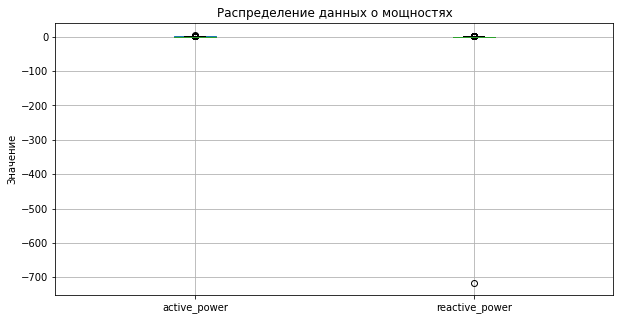

In [12]:
plt.figure(figsize=(10,5))
all_data['df_arc'].boxplot(['active_power','reactive_power'])
plt.title('Распределение данных о мощностях')
plt.ylabel('Значение')
plt.show()

Как и предполагалось, аномальное значение реактивной мощности. Скорее всего ошибочное значение, поэтому избавимся от аномальной партии.

In [13]:
all_data['df_arc'][all_data['df_arc']['reactive_power'] <= -715]

,key,time_start,time_end,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [14]:
all_data['df_arc'] = all_data['df_arc'][all_data['df_arc']['key'] != 2116]

Посмотрим на распределение мощностей.

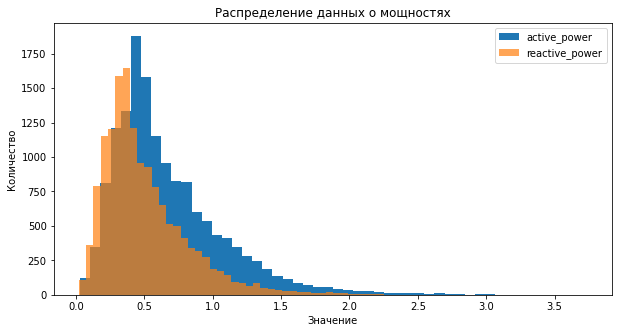

In [15]:
plt.figure(figsize=(10,5))
all_data['df_arc']['active_power'].plot(kind='hist', bins=50)
all_data['df_arc']['reactive_power'].plot(kind='hist', bins=50, alpha=0.7)

plt.title('Распределение данных о мощностях')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.legend()
plt.show()

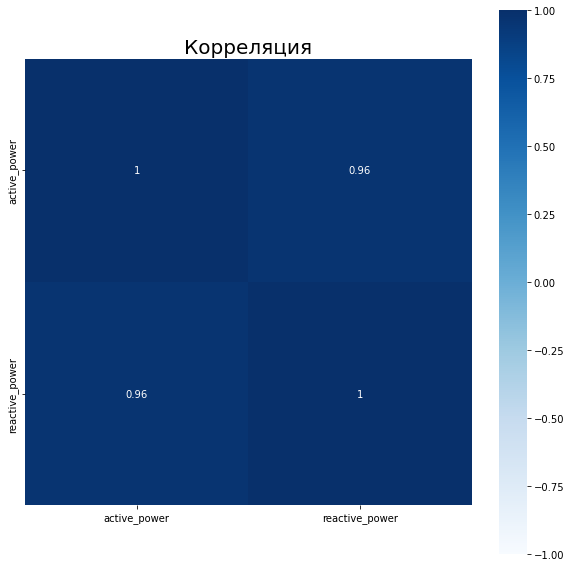

In [16]:
#subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.heatmap(all_data['df_arc'][['active_power','reactive_power']].corr(), annot=True, square=True, vmin=-1, vmax=1, cmap="Blues", ax=ax)
plt.title('Корреляция', size=20)
plt.show()

<img src = 'https://khomovelectro.ru/images/32/clip_image001.jpg'>

Т.к. высокая корреляция может привести к переобучению моделей, то можно попробовать использовать полную мощность. (Можно попробовать  и другие способы разбиения на фичи)

Посмотрел на корреляцию, чтобы убедиться, что мощности действительно связанны, попробуем воспользоваться формулой полной мощности: 
$S^2 = Q^2 + P^2  =>  S = \sqrt{Q^2 + P^2}$

Также предлагаю добавить косинус угла сдвига фаз (коэффициентом мощности):

$cos{fi} = P/S$

Позже добавим расчет W (энергии):

$W = S * T$
- где **T** время работы в секундах

Чтобы модель лучше обучилась, соберем новые фичи. Найдем суммарное время нагрева электродами (сумма значений по всем промежуткам между запусками нагрева электродов), количество запусков нагрева электродов, средняя полная мощность, а также среднюю активную мощность для расчета коэффициента мощности.

In [17]:
arc_tmp = all_data['df_arc'].copy()
arc_tmp['heating_time'] = arc_tmp['time_end'] - arc_tmp['time_start']
arc_tmp['full_power'] = np.sqrt(arc_tmp['active_power']**2 + arc_tmp['reactive_power']**2)
arc_tmp

,key,time_start,time_end,active_power,reactive_power,heating_time,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28,0.807239
...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0 days 00:02:37,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0 days 00:03:00,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0 days 00:03:04,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0 days 00:00:57,0.264489


In [18]:
# Суммарное время нагрева электродами по каждому ключу
time_per_key = arc_tmp.groupby('key')['heating_time'].sum() // pd.Timedelta('1s')
time_per_key = time_per_key.reset_index()
time_per_key.columns = ['key','heating_time_sum_sec']

# Средняя полная мощность
power_per_key = arc_tmp.groupby('key')['full_power'].mean()
power_per_key = power_per_key.reset_index()
power_per_key.columns = ['key','mean_full_power']

# Средняя активная мощность
a_per_key = arc_tmp.groupby('key')['active_power'].mean()
a_per_key = a_per_key.reset_index()
a_per_key.columns = ['key','mean_active_power']

# Количество запусков нагрева электродов
count_heating = arc_tmp.groupby('key')['heating_time'].count()
count_heating = count_heating.reset_index()
count_heating.columns = ['key','heating_time_count']

tmp = power_per_key.merge(time_per_key, on=['key'])
tmp = tmp.merge(count_heating, on=['key'])
tmp = tmp.merge(a_per_key, on=['key'])
del time_per_key, power_per_key, count_heating, a_per_key

In [19]:
# Косинус угла сдвига фаз
tmp['cos_fi'] = tmp['mean_active_power'] / tmp['mean_full_power']

# Нам больше не понадобится активная мощность, поэтому уберем ее сразу
tmp.drop(columns='mean_active_power', inplace=True)

Теперь найдем время начала первого нагрева и время завершения последего нагрева.

In [20]:
all_data['df_arc'][['key','time_start', 'time_end']]

,key,time_start,time_end
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37
...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48


In [21]:
tmp_pivot = all_data['df_arc'][['key','time_start', 'time_end']].pivot_table(index='key', aggfunc=['max','min'])
tmp_pivot = tmp_pivot.reset_index()
tmp_pivot.columns = ['key', 'end_arc_heating', 'del1', 'del2', 'start_arc_heating']
tmp_pivot.drop(columns=['del1', 'del2'], inplace=True)
tmp_pivot.head()

,key,end_arc_heating,start_arc_heating
0,1,2019-05-03 11:28:37,2019-05-03 11:02:14
1,2,2019-05-03 11:53:18,2019-05-03 11:34:14
2,3,2019-05-03 12:32:19,2019-05-03 12:06:54
3,4,2019-05-03 12:57:50,2019-05-03 12:39:37
4,5,2019-05-03 13:33:55,2019-05-03 13:11:13


Соберем фичи в одну таблицу `tmp`.

In [22]:
tmp = tmp.merge(tmp_pivot, on=['key'], how='left')
del tmp_pivot
tmp

,key,mean_full_power,heating_time_sum_sec,heating_time_count,cos_fi,end_arc_heating,start_arc_heating
0,1,1.165279,1098,5,0.837250,2019-05-03 11:28:37,2019-05-03 11:02:14
1,2,0.912304,811,4,0.836508,2019-05-03 11:53:18,2019-05-03 11:34:14
2,3,0.597907,655,5,0.844908,2019-05-03 12:32:19,2019-05-03 12:06:54
3,4,0.953741,741,4,0.841227,2019-05-03 12:57:50,2019-05-03 12:39:37
4,5,1.008939,869,4,0.829379,2019-05-03 13:33:55,2019-05-03 13:11:13
...,...,...,...,...,...,...,...
3208,3237,0.968996,909,5,0.811658,2019-08-31 23:03:48,2019-08-31 22:41:18
3209,3238,0.898847,546,3,0.781196,2019-08-31 23:41:28,2019-08-31 23:26:18
3210,3239,0.701485,1216,8,0.831584,2019-09-01 02:15:43,2019-09-01 01:26:53
3211,3240,0.778371,839,5,0.766751,2019-09-01 03:34:08,2019-09-01 02:35:24


### 1.2 Данные о подаче сыпучих материалов (объём)

In [23]:
first_check('df_bulk')

---------------
#   df_bulk   #
---------------

Первые 5 строк: 
    key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0   
 ------------------------------------------------------------------------------------------

In [24]:
print(f"Кол-во уникальных номеров: {all_data['df_bulk']['key'].unique().shape[0]}")

Кол-во уникальных номеров: 3129


* Имеются пропущенные значение. Связанно со спецификой технологического процесса, объясняется это тем, что в каждую партию добавляют определенное количество материалов.
* Кол-во строк совпадает с кол-вом уникальных значений столбца `key`(кол-вом номеров партий).
* Заменим пропуски на 0 (т.к. поропуск говорит о том, что они (материалы) не были добавлены).

Посмотрим на выбросы.

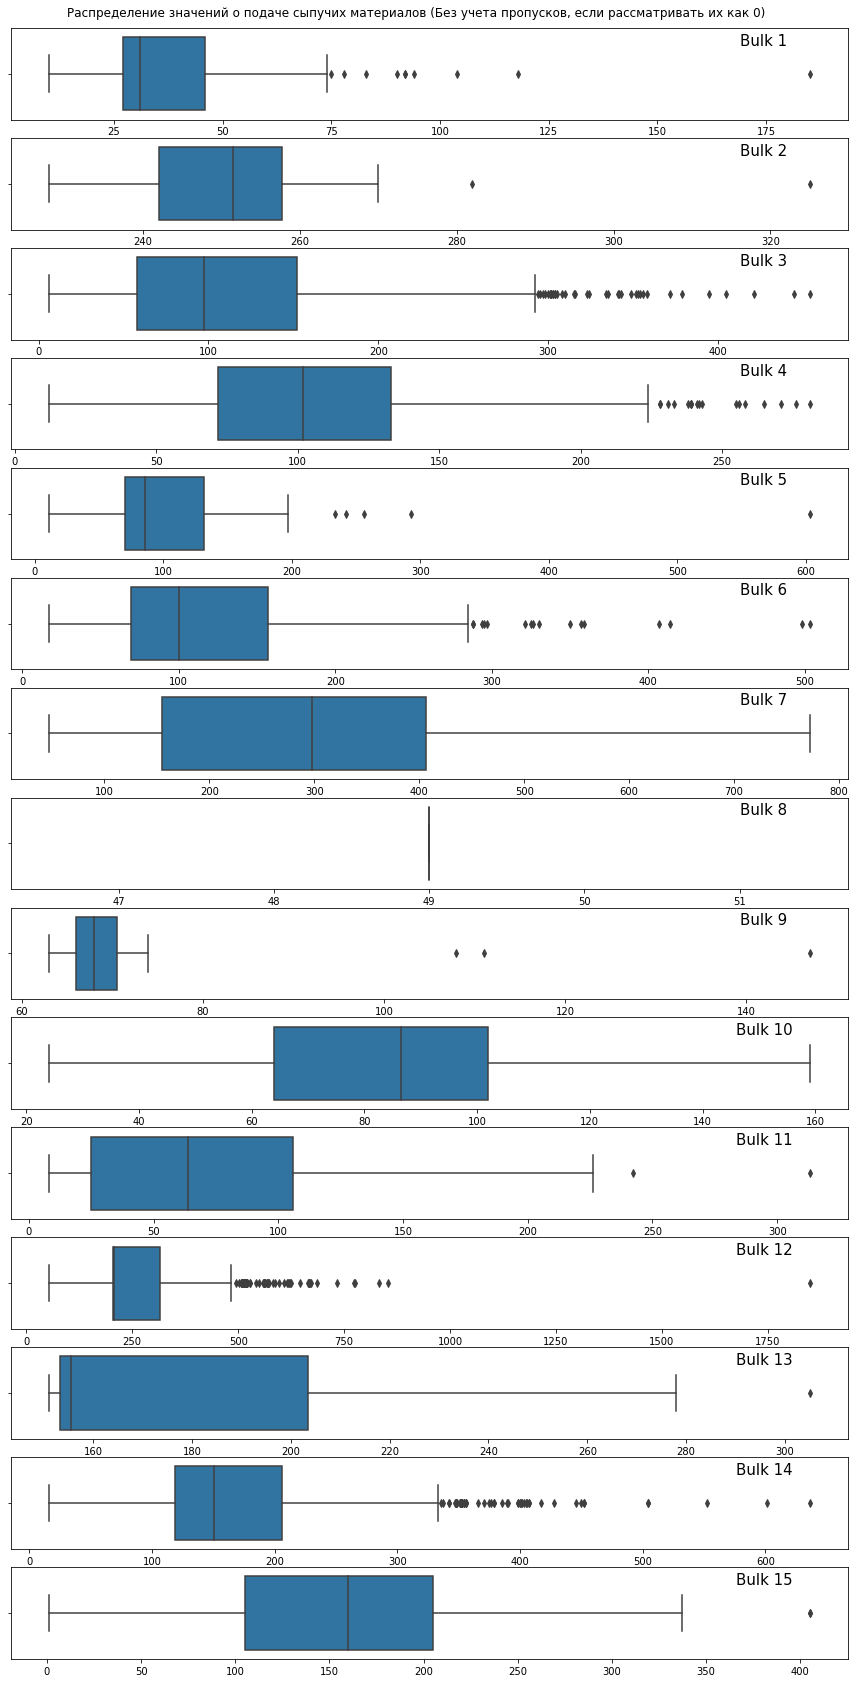

In [25]:
#subplots
fig, axes = plt.subplots(15,1, figsize=(15,30))

for name, line in zip(all_data['df_bulk'].columns[1:], range(all_data['df_bulk'].shape[1]+1)):
    sns.boxplot(all_data['df_bulk'][name], ax=axes[line])
    axes[line].set_title(name, x=0.9, y=0.75, size=15)
    axes[line].set_xlabel('')
    
plt.suptitle('Распределение значений о подаче сыпучих материалов (Без учета пропусков, если рассматривать их как 0)', y=0.89)
plt.show()

In [26]:
all_data['df_bulk'] = all_data['df_bulk'].fillna(0)

При объединении в общий фрейм некоторые из партий могут исчезнуть.

### 1.3 Данные о подаче сыпучих материалов (время)

In [27]:
first_check('df_bulk_time')

--------------------
#   df_bulk_time   #
--------------------

Первые 5 строк: 
    key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56  

Данный фрейм нам не понадобится, поэтому удалим его.

In [28]:
del all_data['df_bulk_time']

### 1.4 Данные о продувке сплава газом

In [29]:
first_check('df_gas')

--------------
#   df_gas   #
--------------

Первые 5 строк: 
    key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692 
 ---------------------------------------------------------------------------------------------------- 
Cуммарная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

 None 
 ---------------------------------------------------------------------------------------------------- 
Сводка:

                key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000  

In [30]:
print(f"Кол-во уникальных номеров: {all_data['df_gas']['key'].unique().shape[0]}")

Кол-во уникальных номеров: 3239


* Кол-во строк совпадает с кол-вом уникальных значений столбца `key`(кол-вом номеров партий).
* Необходимо поправить формат записи столбцов.
* Пропусков не обнаружено.

Заметил, что кол-во уникальных номеров больше чем в `all_data['df_arc']`, это странно т.к. получается, что были партии которые продувались газом без нагрева электродами или же произошел сбой при выгрузке данных.

Т.к. я буду присоединять данный столбец по `key`, то будем внимателенне при объединении фичей в общую.

In [31]:
all_data['df_gas'].rename(columns={'Газ 1': 'gas'}, inplace=True)

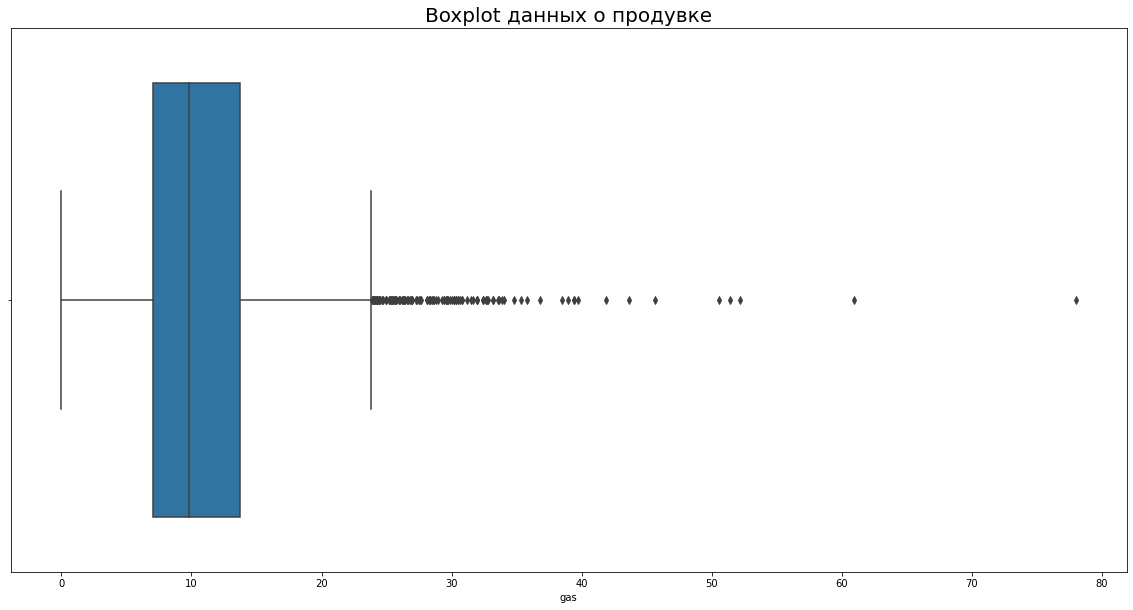

In [32]:
plt.figure(figsize=(20,10))
sns.boxplot(all_data['df_gas']['gas'])
plt.title("Boxplot данных о продувке", size=20)
plt.show()

### 1.5 Результаты измерения температуры

In [33]:
first_check('df_temp')

---------------
#   df_temp   #
---------------

Первые 5 строк: 
    key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0 
 ---------------------------------------------------------------------------------------------------- 
Cуммарная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB

 None 
 ---------------------------------------------------------------------------------------------------- 
Сводка:

                 key   Температура
count  15907.000000

In [34]:
print(f"Кол-во уникальных номеров: {all_data['df_temp']['key'].unique().shape[0]}")

Кол-во уникальных номеров: 3216


* В некоторых партиях отсутствуют замеры температуры
* На каждую партию `key` приходятся несколько температурных замеров.
* Необходимо поправить формат записи столбцов.

In [35]:
all_data['df_temp'].rename(columns={'Время замера': 'time_temperature',
                                    'Температура': 'temperature'}, 
                           inplace=True)

In [36]:
all_data['df_temp']['time_temperature']=pd.to_datetime(all_data['df_temp']['time_temperature'])

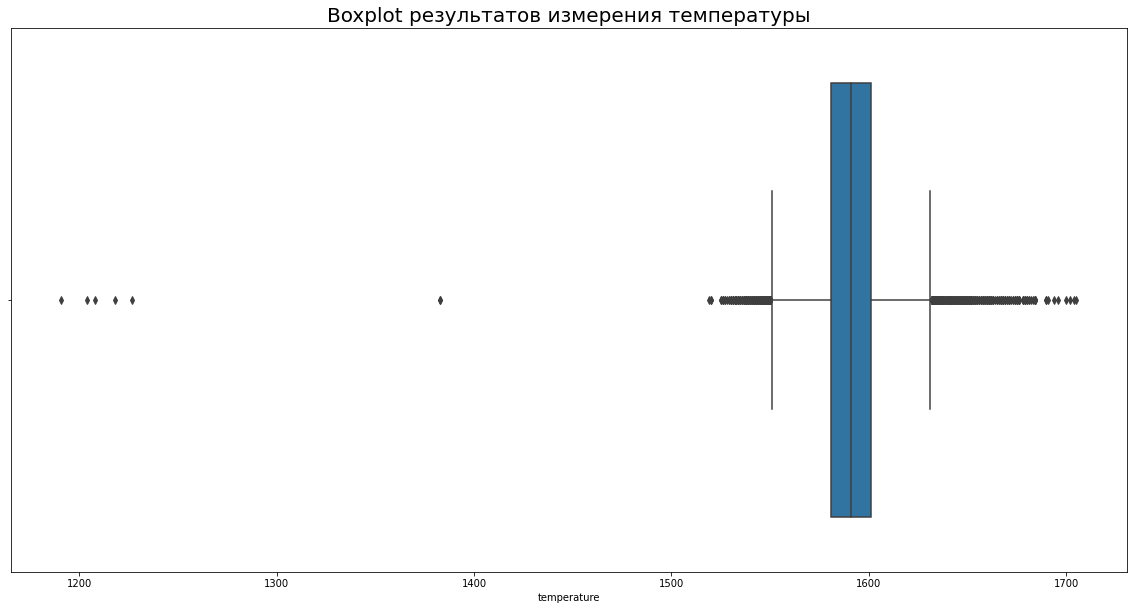

In [37]:
plt.figure(figsize=(20,10))
sns.boxplot(all_data['df_temp']['temperature'])
plt.title("Boxplot результатов измерения температуры", size=20)
plt.show()

Есть пропущенные значения, их мы удалим, потому что в нашем случае усреднить и заполнить не получится, т.к. идет зависимость по времени и материалу сплава. А удалим мы их по причине того, что данные без значения температуры не несут для нас никакой информации.

Теперь определим первую и последнюю замеры теператур партий.

In [38]:
df_temp_pivot = all_data['df_temp'].pivot_table(index='key', aggfunc=['max','min'])
df_temp_pivot = df_temp_pivot.reset_index()
df_temp_pivot.columns = ['key', 'temp_end', 'time_temperature', 'temp_start', 'start_time_temperature']
df_temp_pivot.head()

,key,temp_end,time_temperature,temp_start,start_time_temperature
0,1,1618.0,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18
1,2,1608.0,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27
2,3,1599.0,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17
3,4,1625.0,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57
4,5,1602.0,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19


Удалим столбец `temp_end`, так как присвоенные данные по последнему замеру температуры могут не соответстветствовать своему времени если были допущены пропуски.

Добавим температуру последнего замера позже.

In [39]:
df_temp_pivot = df_temp_pivot.drop(columns=['temp_end'])
df_temp_pivot

,key,time_temperature,temp_start,start_time_temperature
0,1,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18
1,2,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27
2,3,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17
3,4,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57
4,5,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19
...,...,...,...,...
3211,3237,2019-08-31 23:05:43,1569.0,2019-08-31 22:44:04
3212,3238,2019-08-31 23:43:00,1584.0,2019-08-31 23:30:31
3213,3239,2019-09-01 02:24:15,1598.0,2019-09-01 01:31:47
3214,3240,2019-09-01 03:35:16,1617.0,2019-09-01 02:39:01


In [40]:
df_temp_pivot=df_temp_pivot.merge(all_data['df_temp'], on=['key', 'time_temperature'], how='left')
df_temp_pivot.rename(columns={'time_temperature' : 'end_time_temperature', 'temperature': 'end_temp'}, inplace=True)
df_temp_pivot

,key,end_time_temperature,temp_start,start_time_temperature,end_temp
0,1,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18,1613.0
1,2,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27,1602.0
2,3,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17,1599.0
3,4,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57,1625.0
4,5,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19,1602.0
...,...,...,...,...,...
3211,3237,2019-08-31 23:05:43,1569.0,2019-08-31 22:44:04,NaN
3212,3238,2019-08-31 23:43:00,1584.0,2019-08-31 23:30:31,NaN
3213,3239,2019-09-01 02:24:15,1598.0,2019-09-01 01:31:47,NaN
3214,3240,2019-09-01 03:35:16,1617.0,2019-09-01 02:39:01,NaN


Мы видим пропущенные значения в целевом признаке "temperature", мы эти данные никак не узнаем, ни через среднее, ни через медиану, пооэтому просто удалим строки без замеренных данных по температуре.

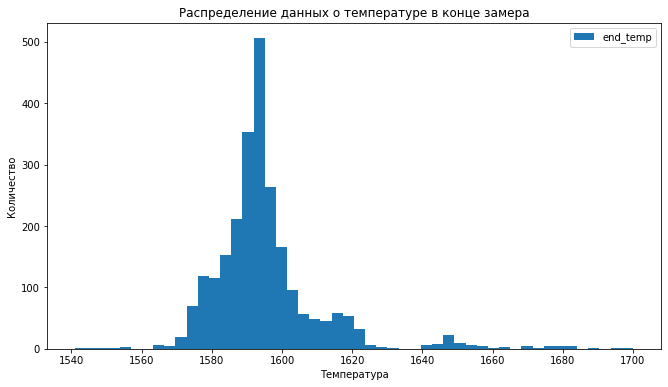

In [41]:
df_temp_pivot=df_temp_pivot.dropna(subset=['end_temp'])

plt.figure(figsize=(11,6))
df_temp_pivot['end_temp'].plot(kind='hist', bins=50, legend=True)
plt.title('Распределение данных о температуре в конце замера')
plt.xlabel('Температура')
plt.ylabel('Количество')
plt.show()

Чтобы модель лучше обучилась, добавим новые фичи. Найдем длительность времени между первым и последним замером температуры

In [42]:
df_temp_pivot['temperature_difference_sec'] = (df_temp_pivot['end_time_temperature'] - df_temp_pivot['start_time_temperature']) // pd.Timedelta('1s')
df_temp_pivot

,key,end_time_temperature,temp_start,start_time_temperature,end_temp,temperature_difference_sec
0,1,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18,1613.0,861
1,2,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27,1602.0,1305
2,3,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17,1599.0,1300
3,4,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57,1625.0,388
4,5,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19,1602.0,762
...,...,...,...,...,...,...
2472,2495,2019-08-06 00:54:42,1570.0,2019-08-06 00:35:45,1591.0,1137
2473,2496,2019-08-06 01:29:52,1554.0,2019-08-06 01:02:54,1591.0,1618
2474,2497,2019-08-06 01:53:50,1571.0,2019-08-06 01:41:53,1589.0,717
2475,2498,2019-08-06 02:25:31,1570.0,2019-08-06 02:03:49,1594.0,1302


__Мы не можем исключать партии где первая температура = последней__ только потому, что у нас была фиксация нагрева электродов и у нас есть сомнения в детектировании температуры.

В `2 Подготовка фрейма для обучения` мы рассмматривали такие случаи, у нас могут быть партии где снимались температурные показания за 500 сек (8,33 мин) до нагрева и после нагрева брали только через 2000 сек (33,33 минуты) за такое время наша сталь могла остыть до входных значений.

In [43]:
df_temp_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   key                         2477 non-null   int64         
 1   end_time_temperature        2477 non-null   datetime64[ns]
 2   temp_start                  2477 non-null   float64       
 3   start_time_temperature      2477 non-null   datetime64[ns]
 4   end_temp                    2477 non-null   float64       
 5   temperature_difference_sec  2477 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 135.5 KB


### 1.6 Данные о проволочных материалах (объём)

In [44]:
first_check('df_wire')

---------------
#   df_wire   #
---------------

Первые 5 строк: 
    key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN   
 ---------------------------------------------------------------------------------------------------- 
Cуммарная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2

In [45]:
print(f"Кол-во уникальных номеров: {all_data['df_wire']['key'].unique().shape[0]}")

Кол-во уникальных номеров: 3081


* Имеются пропущенные значение. Связанно со спецификой технологического процесса, объясняется это тем, что в каждую партию добавляют определенное количество материалов.
* Заменим пропуски на 0 (т.к. поропуск говорит о том, что они (материалы) не были добавлены).

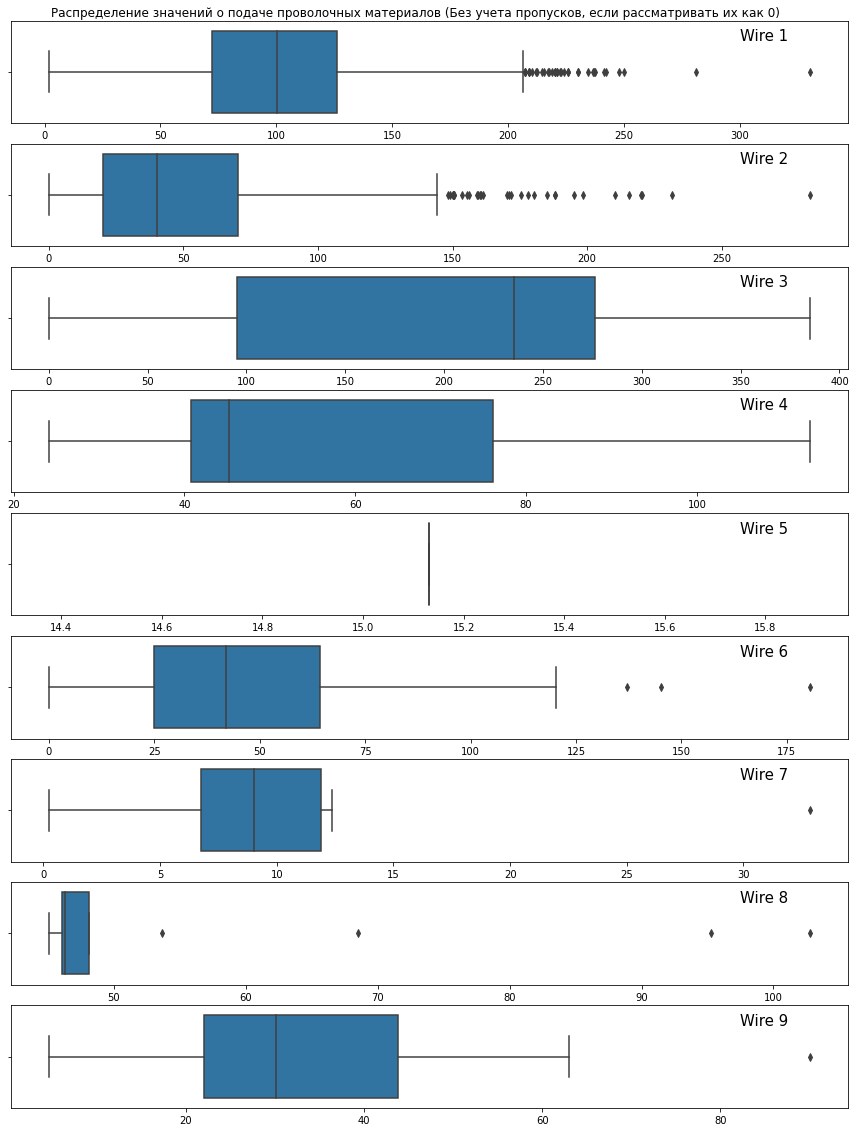

In [46]:
#subplots
fig, axes = plt.subplots(9,1, figsize=(15,20))

for name, line in zip(all_data['df_wire'].columns[1:], range(all_data['df_wire'].shape[1]+1)):
    sns.boxplot(all_data['df_wire'][name], ax=axes[line])
    axes[line].set_title(name, x=0.9, y=0.75, size=15)
    axes[line].set_xlabel('')
    
plt.suptitle('Распределение значений о подаче проволочных материалов (Без учета пропусков, если рассматривать их как 0)', y=0.89)
plt.show()

In [47]:
all_data['df_wire'] = all_data['df_wire'].fillna(0)

### 1.7 Данные о проволочных материалах (время)

In [48]:
first_check('df_wire_time')

--------------------
#   df_wire_time   #
--------------------

Первые 5 строк: 
    key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN   
 ---------------------------------------------------------------------------------------------------- 
Cуммарная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  -----

Данный фрейм нам не понадобится, поэтому удалим его.

In [49]:
del all_data['df_wire_time']

### Промежуточный вывод

* Мы посмотрели и немного подчистили входные данные.
* В пунктах `1.1 Данные об электродах` и `1.5 Результаты измерения температуры` мы подготовили фичи для обучения.
* В пунктах `1.2`,`1.4` и `1.6` заменили пропуски 0
* Данные подготовлены для дальнейшего объединения.

## 2 Подготовка фрейма для обучения

Объединим все интересующие нас признаки в одну таблицу.

В пунктах `1.1 Данные об электродах` и `1.5 Результаты измерения температуры` мы подготовили фичи, теперь можем их объединить по `key`

In [50]:
tmp

,key,mean_full_power,heating_time_sum_sec,heating_time_count,cos_fi,end_arc_heating,start_arc_heating
0,1,1.165279,1098,5,0.837250,2019-05-03 11:28:37,2019-05-03 11:02:14
1,2,0.912304,811,4,0.836508,2019-05-03 11:53:18,2019-05-03 11:34:14
2,3,0.597907,655,5,0.844908,2019-05-03 12:32:19,2019-05-03 12:06:54
3,4,0.953741,741,4,0.841227,2019-05-03 12:57:50,2019-05-03 12:39:37
4,5,1.008939,869,4,0.829379,2019-05-03 13:33:55,2019-05-03 13:11:13
...,...,...,...,...,...,...,...
3208,3237,0.968996,909,5,0.811658,2019-08-31 23:03:48,2019-08-31 22:41:18
3209,3238,0.898847,546,3,0.781196,2019-08-31 23:41:28,2019-08-31 23:26:18
3210,3239,0.701485,1216,8,0.831584,2019-09-01 02:15:43,2019-09-01 01:26:53
3211,3240,0.778371,839,5,0.766751,2019-09-01 03:34:08,2019-09-01 02:35:24


In [51]:
df_temp_pivot

,key,end_time_temperature,temp_start,start_time_temperature,end_temp,temperature_difference_sec
0,1,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18,1613.0,861
1,2,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27,1602.0,1305
2,3,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17,1599.0,1300
3,4,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57,1625.0,388
4,5,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19,1602.0,762
...,...,...,...,...,...,...
2472,2495,2019-08-06 00:54:42,1570.0,2019-08-06 00:35:45,1591.0,1137
2473,2496,2019-08-06 01:29:52,1554.0,2019-08-06 01:02:54,1591.0,1618
2474,2497,2019-08-06 01:53:50,1571.0,2019-08-06 01:41:53,1589.0,717
2475,2498,2019-08-06 02:25:31,1570.0,2019-08-06 02:03:49,1594.0,1302


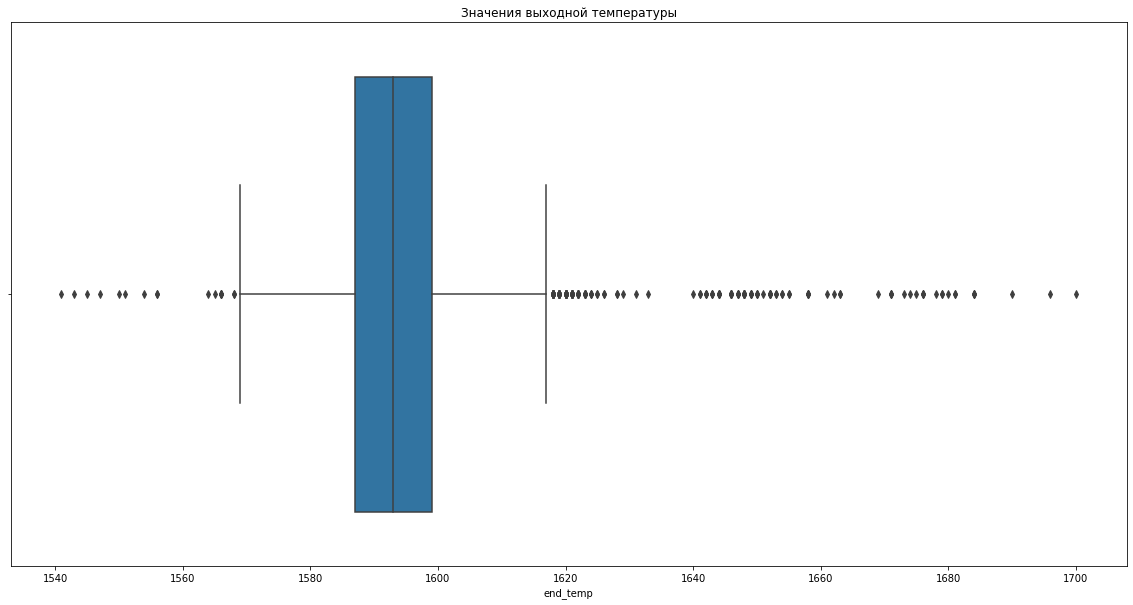

In [52]:
plt.figure(figsize=(20,10))
sns.boxplot(df_temp_pivot['end_temp'])
plt.title('Значения выходной температуры')
plt.show()

Значения выходной температуры вышее чем температура плавления стали`~1370`, следовательно данные похожи на правду.

Замечаем, что у нас есть случаи когда первые температурные показания по партии происходят после начала нагрева и последние после завершения последнего нагрева электродов.

In [53]:
tmp = df_temp_pivot.merge(tmp, on=['key'], how='inner')
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474 entries, 0 to 2473
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   key                         2474 non-null   int64         
 1   end_time_temperature        2474 non-null   datetime64[ns]
 2   temp_start                  2474 non-null   float64       
 3   start_time_temperature      2474 non-null   datetime64[ns]
 4   end_temp                    2474 non-null   float64       
 5   temperature_difference_sec  2474 non-null   int64         
 6   mean_full_power             2474 non-null   float64       
 7   heating_time_sum_sec        2474 non-null   int64         
 8   heating_time_count          2474 non-null   int64         
 9   cos_fi                      2474 non-null   float64       
 10  end_arc_heating             2474 non-null   datetime64[ns]
 11  start_arc_heating           2474 non-null   datetime64[n

In [54]:
tmp

,key,end_time_temperature,temp_start,start_time_temperature,end_temp,temperature_difference_sec,mean_full_power,heating_time_sum_sec,heating_time_count,cos_fi,end_arc_heating,start_arc_heating
0,1,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18,1613.0,861,1.165279,1098,5,0.837250,2019-05-03 11:28:37,2019-05-03 11:02:14
1,2,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27,1602.0,1305,0.912304,811,4,0.836508,2019-05-03 11:53:18,2019-05-03 11:34:14
2,3,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17,1599.0,1300,0.597907,655,5,0.844908,2019-05-03 12:32:19,2019-05-03 12:06:54
3,4,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57,1625.0,388,0.953741,741,4,0.841227,2019-05-03 12:57:50,2019-05-03 12:39:37
4,5,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19,1602.0,762,1.008939,869,4,0.829379,2019-05-03 13:33:55,2019-05-03 13:11:13
...,...,...,...,...,...,...,...,...,...,...,...,...
2469,2495,2019-08-06 00:54:42,1570.0,2019-08-06 00:35:45,1591.0,1137,0.996717,723,4,0.805316,2019-08-06 00:51:13,2019-08-06 00:31:05
2470,2496,2019-08-06 01:29:52,1554.0,2019-08-06 01:02:54,1591.0,1618,0.842839,940,6,0.831133,2019-08-06 01:23:32,2019-08-06 01:00:06
2471,2497,2019-08-06 01:53:50,1571.0,2019-08-06 01:41:53,1589.0,717,0.961672,569,3,0.766851,2019-08-06 01:50:45,2019-08-06 01:38:01
2472,2498,2019-08-06 02:25:31,1570.0,2019-08-06 02:03:49,1594.0,1302,0.828750,750,5,0.822619,2019-08-06 02:20:24,2019-08-06 01:57:46


In [55]:
tmp['dif_start'] = (tmp['start_time_temperature'] - tmp['start_arc_heating']) // pd.Timedelta('1s')
tmp['dif_end'] = (tmp['end_time_temperature'] - tmp['end_arc_heating']) // pd.Timedelta('1s')

# Также добавим W
tmp['mean_energy'] = (tmp['mean_full_power'] * tmp['heating_time_sum_sec'])

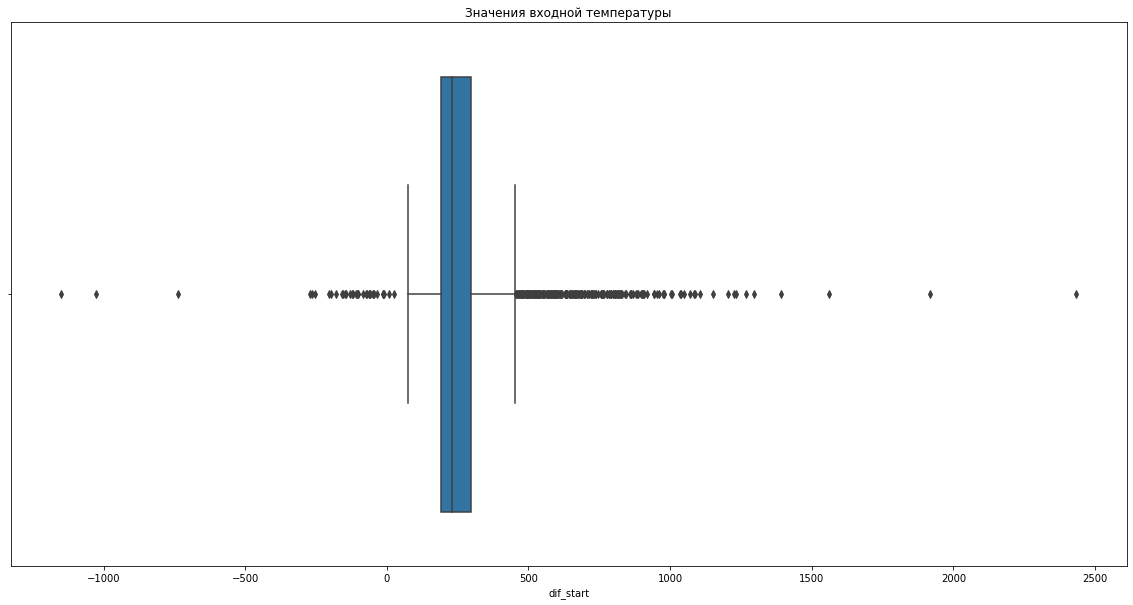

In [56]:
plt.figure(figsize=(20,10))
sns.boxplot(tmp['dif_start'])
plt.title('Значения входной температуры')
plt.show()

Действительно есть случаи, когда замеры происходят во время включения и после первого нагрева.

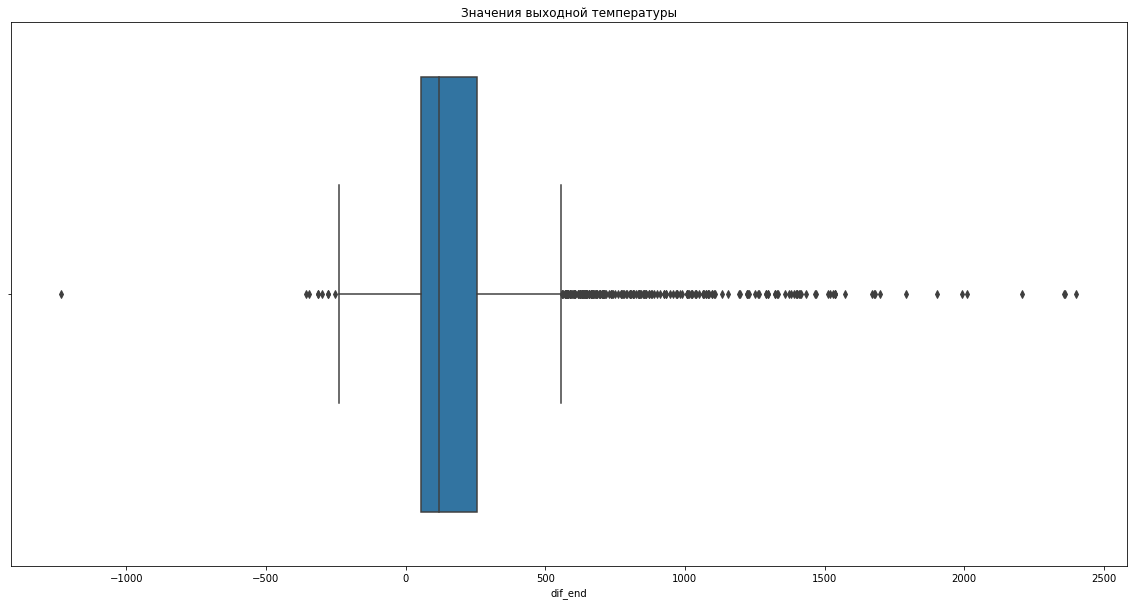

In [57]:
plt.figure(figsize=(20,10))
sns.boxplot(tmp['dif_end'])
plt.title('Значения выходной температуры')
plt.show()

С последним нагревом мы тоже не ошиблись, здесь нас интересует замер после нагрева или во время завершения нагрева.

In [58]:
tmp

,key,end_time_temperature,temp_start,start_time_temperature,end_temp,temperature_difference_sec,mean_full_power,heating_time_sum_sec,heating_time_count,cos_fi,end_arc_heating,start_arc_heating,dif_start,dif_end,mean_energy
0,1,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18,1613.0,861,1.165279,1098,5,0.837250,2019-05-03 11:28:37,2019-05-03 11:02:14,844,122,1279.476327
1,2,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27,1602.0,1305,0.912304,811,4,0.836508,2019-05-03 11:53:18,2019-05-03 11:34:14,193,354,739.878624
2,3,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17,1599.0,1300,0.597907,655,5,0.844908,2019-05-03 12:32:19,2019-05-03 12:06:54,383,158,391.628975
3,4,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57,1625.0,388,0.953741,741,4,0.841227,2019-05-03 12:57:50,2019-05-03 12:39:37,800,95,706.721780
4,5,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19,1602.0,762,1.008939,869,4,0.829379,2019-05-03 13:33:55,2019-05-03 13:11:13,726,126,876.768387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,2495,2019-08-06 00:54:42,1570.0,2019-08-06 00:35:45,1591.0,1137,0.996717,723,4,0.805316,2019-08-06 00:51:13,2019-08-06 00:31:05,280,209,720.626482
2470,2496,2019-08-06 01:29:52,1554.0,2019-08-06 01:02:54,1591.0,1618,0.842839,940,6,0.831133,2019-08-06 01:23:32,2019-08-06 01:00:06,168,380,792.268493
2471,2497,2019-08-06 01:53:50,1571.0,2019-08-06 01:41:53,1589.0,717,0.961672,569,3,0.766851,2019-08-06 01:50:45,2019-08-06 01:38:01,232,185,547.191525
2472,2498,2019-08-06 02:25:31,1570.0,2019-08-06 02:03:49,1594.0,1302,0.828750,750,5,0.822619,2019-08-06 02:20:24,2019-08-06 01:57:46,363,307,621.562327


Замечательно, теперь добавим фичи о подаче проволочных/сыпучих материалов, а также добавим фичи о подаче газа.

In [59]:
tmp = tmp.merge(all_data['df_gas'], on=['key'], how='inner')
tmp = tmp.merge(all_data['df_bulk'], on=['key'], how='inner')
tmp = tmp.merge(all_data['df_wire'], on=['key'], how='inner')

In [60]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   key                         2328 non-null   int64         
 1   end_time_temperature        2328 non-null   datetime64[ns]
 2   temp_start                  2328 non-null   float64       
 3   start_time_temperature      2328 non-null   datetime64[ns]
 4   end_temp                    2328 non-null   float64       
 5   temperature_difference_sec  2328 non-null   int64         
 6   mean_full_power             2328 non-null   float64       
 7   heating_time_sum_sec        2328 non-null   int64         
 8   heating_time_count          2328 non-null   int64         
 9   cos_fi                      2328 non-null   float64       
 10  end_arc_heating             2328 non-null   datetime64[ns]
 11  start_arc_heating           2328 non-null   datetime64[n

Теперь уберем колонки с форматами `datetime`, а так же колонку `key`, ибо эти данные не несут никаких бизнес-показателй для определения целевого признака.(`end_temp`)

In [61]:
tmp.drop(columns=['key', 'end_time_temperature', 'start_time_temperature', 'end_arc_heating', 'start_arc_heating', 'dif_start', 'dif_end'], inplace=True)

In [62]:
tmp

,temp_start,end_temp,temperature_difference_sec,mean_full_power,heating_time_sum_sec,heating_time_count,cos_fi,mean_energy,gas,Bulk 1,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1613.0,861,1.165279,1098,5,0.837250,1279.476327,29.749986,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1577.0,1602.0,1305,0.912304,811,4,0.836508,739.878624,12.555561,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,1300,0.597907,655,5,0.844908,391.628975,28.554793,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,388,0.953741,741,4,0.841227,706.721780,18.841219,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,762,1.008939,869,4,0.829379,876.768387,5.413692,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,1570.0,1591.0,1137,0.996717,723,4,0.805316,720.626482,7.125735,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2324,1554.0,1591.0,1618,0.842839,940,6,0.831133,792.268493,9.412616,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,1571.0,1589.0,717,0.961672,569,3,0.766851,547.191525,6.271699,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,1570.0,1594.0,1302,0.828750,750,5,0.822619,621.562327,14.953657,0.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь взглянем на, получившуюся у нас, карту линейной корреляции.

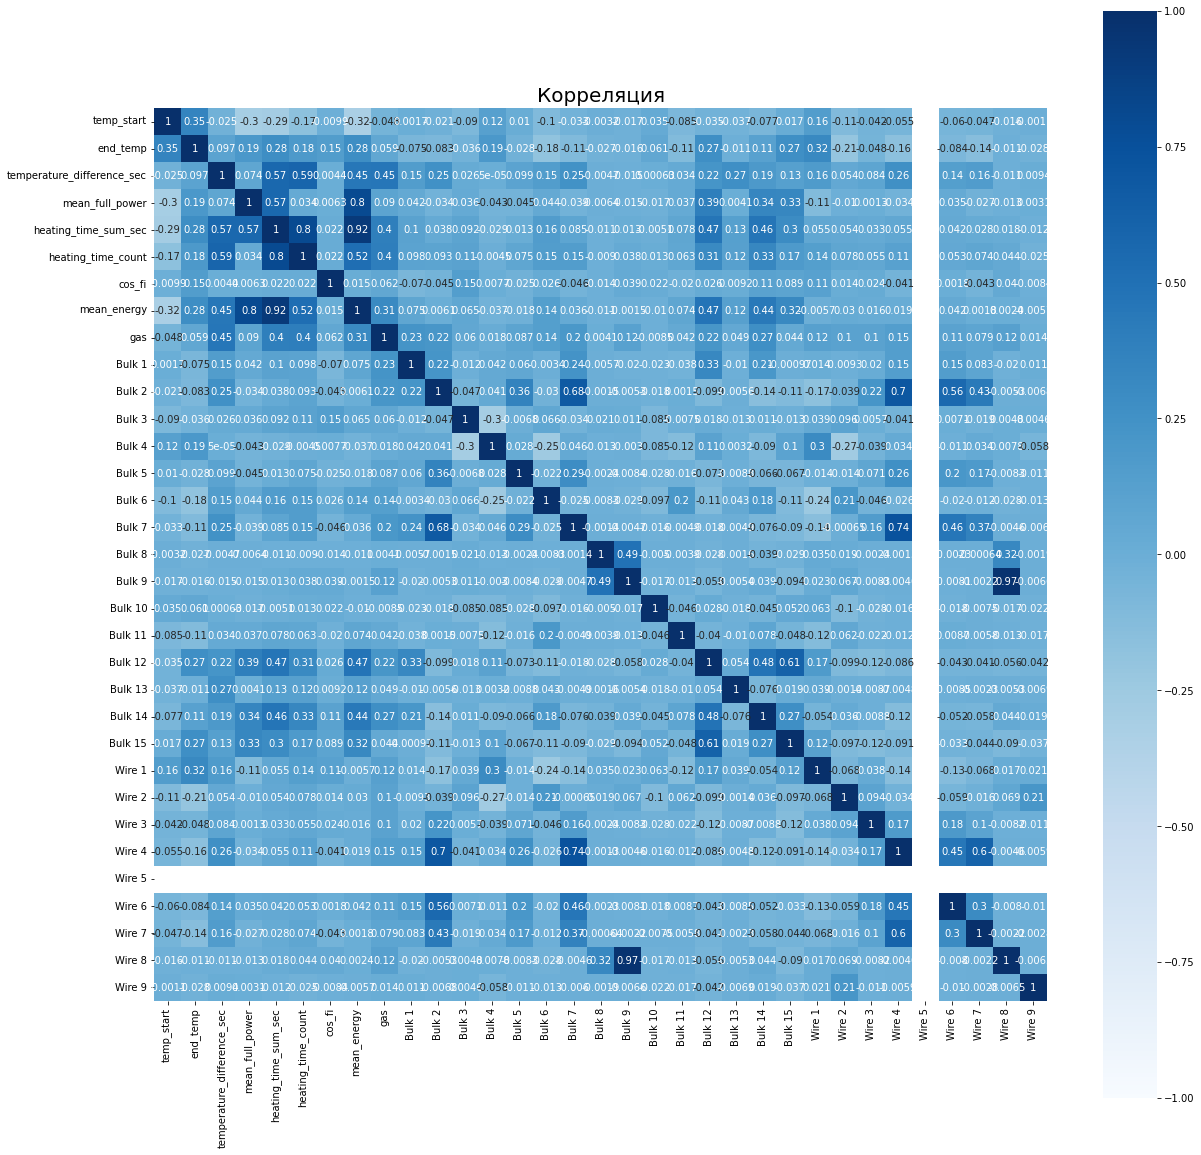

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

sns.heatmap(tmp.corr(), annot=True, square=True, vmin=-1, vmax=1, cmap="Blues", ax=ax)
plt.title('Корреляция', size=20)
plt.show()

In [64]:
tmp['Wire 5'].unique()

array([0.])

Сразу избавимся от этого столбца

In [65]:
tmp.drop(columns='Wire 5', inplace=True)

Руководствуясь шкалой Чеддока, замечаем, что у нас есть случаи весьма высокой линейной связи, можем попробовать обучить на таких фичах, после посмотреть на скор и feature_importance, а затем попробовать почистить фрейм фичей.

### Промежуточный вывод

* Получилось отобрать всего 2092 партии.
* Данные предобработаны, с пропущенными значениями и аномалиями разобрались, все необходимые признаки собрали в финальную таблицу.
* Буду придерживаться стратегии по исключению фичей на этапе обучения.

***

## 3. Обучение моделей

Данные были подготовлены для обучения модели.

Выделим целевой признак конечной температуры `end_temp`. Остальные же столбцы, или фичи, будут использованы для предсказания.

Разобьем данные на train и test к соотношению 80/20.

In [66]:
f = tmp.drop(columns='end_temp')
t = tmp['end_temp']

In [67]:
f_train, f_test, t_train, t_test = train_test_split(f, t, test_size=0.2, random_state=RND, shuffle=True)

In [68]:
train_sample=f_train.shape[0]/f.shape[0]
test_sample=f_test.shape[0]/f.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 80%
Размер тестовой выборки - 20%


Выберем следующие модели для задачи регрессии:

* DecisionTreeRegressor
* RandomForest
* SimpleBoostReg (Попробуем реализовать свой бустинг на пеньках)
* LGBMRegressor
* CatBoostRegressor

### 3.1 DecisionTreeRegressor

In [69]:
%%time

parametrs_dt = { 
    'max_depth': range (1,10),          
    'min_samples_leaf': range (1,5),
}

model_dt = DecisionTreeRegressor(random_state=RND)  
grid_dt = GridSearchCV(model_dt, parametrs_dt, cv=5, scoring='neg_mean_absolute_error')
grid_dt.fit(f_train,t_train)
best_score_dt = -1*grid_dt.best_score_
parametrs_dt = pd.Series(grid_dt.best_params_)[0]
predict_dt=grid_dt.predict(f_test)
print('Значение MAE на тренировочных данных равно: {:.2f}'.format(best_score_dt), '\nМаксимальная глубина:',parametrs_dt)

Значение MAE на тренировочных данных равно: 5.25 
Максимальная глубина: 7
CPU times: total: 2.3 s
Wall time: 2.29 s


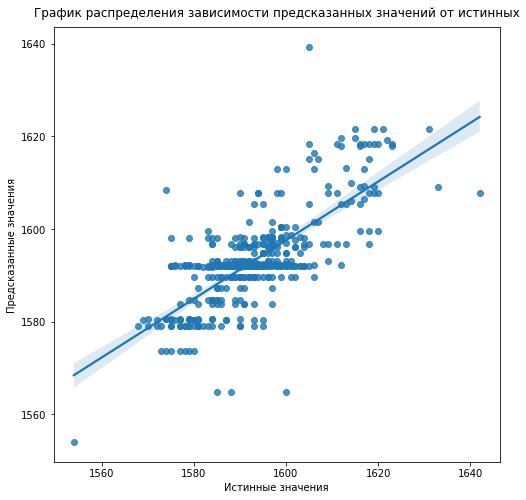

MAE модели DecisionTreeRegressor : 5.55
RMSE модели DecisionTreeRegressor : 7.76


In [70]:
res_dt = graph('DecisionTreeRegressor',predict_dt)

### 3.2 RandomForest

In [71]:
model_rf = RandomForestRegressor(criterion = "mae", random_state=RND, n_jobs=-1)
model_rf.fit(f_train,t_train)
predict_rf=model_rf.predict(f_test)

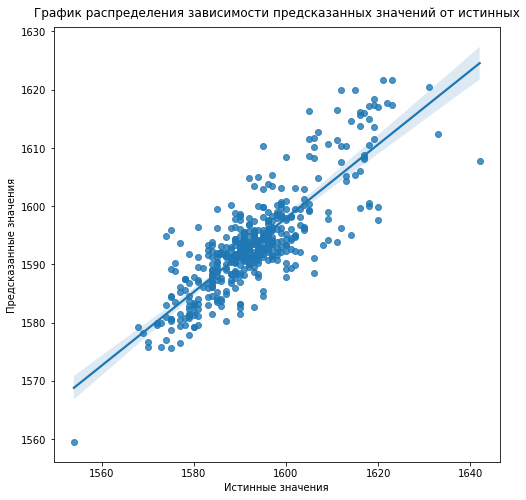

MAE модели RandomForest : 4.60
RMSE модели RandomForest : 6.30


In [72]:
res_rf = graph('RandomForest', predict_rf)

### 3.3 SimpleBoostReg (Попробуем реализовать свой бустинг на пеньках)

In [73]:
%%time

n = 1000
nu = 0.1
trees = []

train = f_train.copy()
train['end_temp'] = t_train.copy()
test = f_test.copy()
test['end_temp'] = t_test.copy()
train['y_pred'] = train['end_temp'].mean()

for i in trange(n):
    train['residual'] = train['end_temp'] - train['y_pred']
    tree = DecisionTreeRegressor(max_depth=1, random_state=RND)
    tree.fit(train.drop(['y_pred', 'residual', 'end_temp'], axis=1), train['residual'])
    train['y_pred'] += nu * tree.predict(train.drop(['y_pred', 'residual', 'end_temp'], axis=1))
    trees.append(tree)
    
print(f'MAE score on train sample: {round(mae(train["end_temp"], train["y_pred"]), 3)}\n')

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.46it/s]

MAE score on train sample: 3.774

CPU times: total: 9.11 s
Wall time: 9.06 s


In [74]:
test['y_pred'] = test['end_temp'].mean()

for tree in trees:
    test['y_pred'] += nu * tree.predict(test.drop(['y_pred', 'end_temp'], axis=1))

print(f'Test MAE = {round(mae(test["end_temp"], test["y_pred"]), 3)}\n')

Test MAE = 4.596



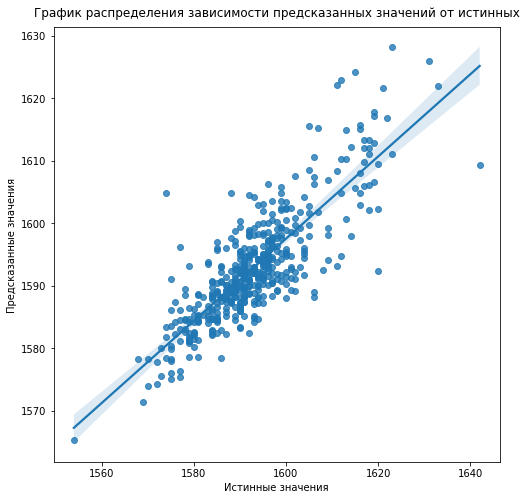

MAE модели бустинг на пеньках : 4.60
RMSE модели бустинг на пеньках : 6.33


In [75]:
res_sb = graph('бустинг на пеньках', test["y_pred"])

### 3.4 LGBMRegressor

In [76]:
%%time

model_lgb = LGBMRegressor(random_state=RND, boosting_type='gbdt', num_iterations=1500)
model_lgb.fit(f_train,t_train)
predict_lgb=model_lgb.predict(f_test)

CPU times: total: 36.9 s
Wall time: 1.61 s


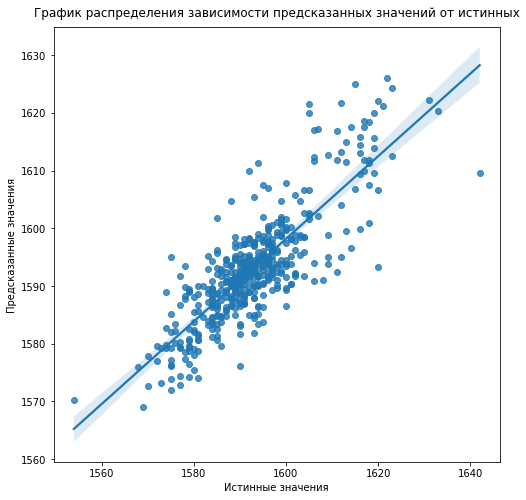

MAE модели LGBMRegressor : 4.61
RMSE модели LGBMRegressor : 6.35


In [77]:
res_lgb = graph('LGBMRegressor', predict_lgb)

### 3.5 CatBoostRegressor

In [78]:
%%time

model_cat = CatBoostRegressor(loss_function="MAE", verbose=100, iterations=1500)
model_cat.fit(f_train,t_train, eval_set=(f_test,t_test))
predict_cat=model_cat.predict(f_test)

0:	learn: 7.8979474	test: 8.1820162	best: 8.1820162 (0)	total: 134ms	remaining: 3m 21s
100:	learn: 4.4831422	test: 5.0258502	best: 5.0258502 (100)	total: 391ms	remaining: 5.42s
200:	learn: 3.7426824	test: 4.5951216	best: 4.5951216 (200)	total: 638ms	remaining: 4.12s
300:	learn: 3.3225995	test: 4.4175601	best: 4.4175601 (300)	total: 874ms	remaining: 3.48s
400:	learn: 3.0316798	test: 4.3412696	best: 4.3400150 (396)	total: 1.12s	remaining: 3.08s
500:	learn: 2.8417813	test: 4.3097820	best: 4.3087921 (493)	total: 1.36s	remaining: 2.72s
600:	learn: 2.6638208	test: 4.2908444	best: 4.2897826 (554)	total: 1.6s	remaining: 2.39s
700:	learn: 2.5428273	test: 4.2847058	best: 4.2827416 (675)	total: 1.84s	remaining: 2.09s
800:	learn: 2.4414260	test: 4.2836626	best: 4.2827416 (675)	total: 2.07s	remaining: 1.81s
900:	learn: 2.3524921	test: 4.2763754	best: 4.2763754 (900)	total: 2.32s	remaining: 1.54s
1000:	learn: 2.2946940	test: 4.2750436	best: 4.2722590 (935)	total: 2.56s	remaining: 1.28s
1100:	learn: 

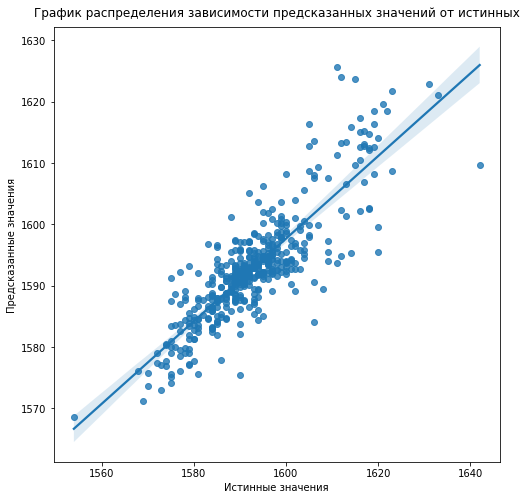

MAE модели CatBoostRegressor : 4.26
RMSE модели CatBoostRegressor : 5.99


In [79]:
res_cat = graph('CatBoostRegressor',predict_cat)

### Промежуточный вывод

In [80]:
col = ["MAE", "RMSE"]
ind = [
    'DecisionTreeRegressor',
    'RandomForest',
    'Бустинг на пеньках',
    'LGBMRegressor',
    'CatBoostRegressor',
]

report = pd.DataFrame(
    columns=col,
    index=ind
)

report.iloc[0] = [res_dt['mae'], res_dt['rmse']]
report.iloc[1] = [res_rf['mae'], res_rf['rmse']]
report.iloc[2] = [res_sb['mae'], res_sb['rmse']]
report.iloc[3] = [res_lgb['mae'], res_lgb['rmse']]
report.iloc[4] = [res_cat['mae'], res_cat['rmse']]

display(report)

,MAE,RMSE
DecisionTreeRegressor,5.547318,7.760808
RandomForest,4.599356,6.303007
Бустинг на пеньках,4.595859,6.32627
LGBMRegressor,4.610919,6.354368
CatBoostRegressor,4.262444,5.986048


Все модели уже преодалели порог в $MAE < 6.00$

Лучший результат по $MAE$ показал `CatBoostRegressor`.

Теперь найдём факторы важности наилучшей модели, и посмотрим, какие признаки могут быть лишними, и какие можем удалить.

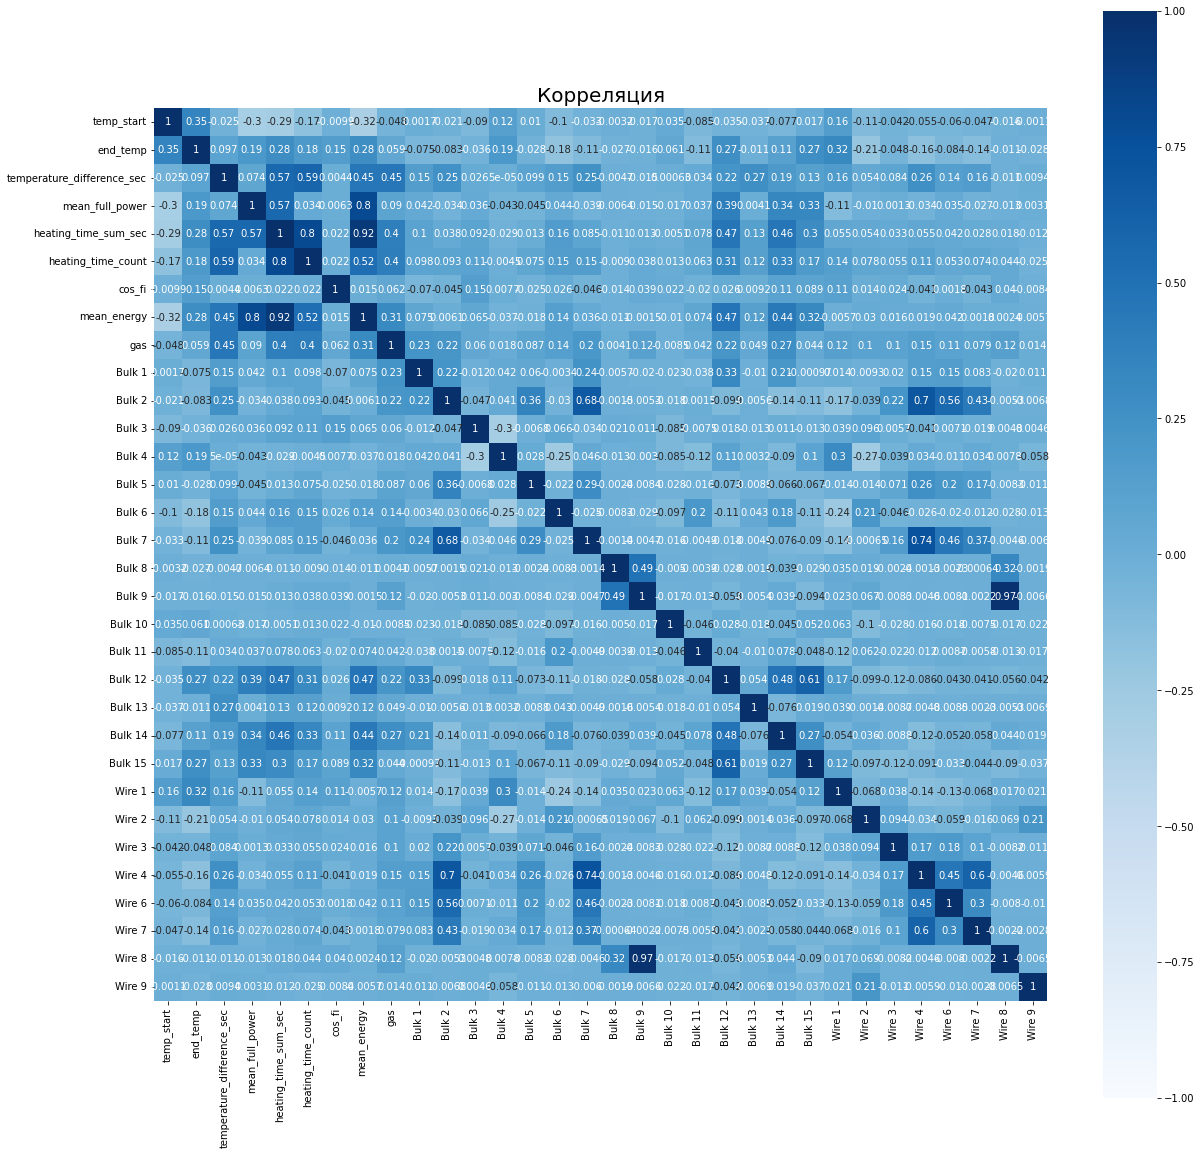

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

sns.heatmap(tmp.corr(), annot=True, square=True, vmin=-1, vmax=1, cmap="Blues", ax=ax)
plt.title('Корреляция', size=20)
plt.show()

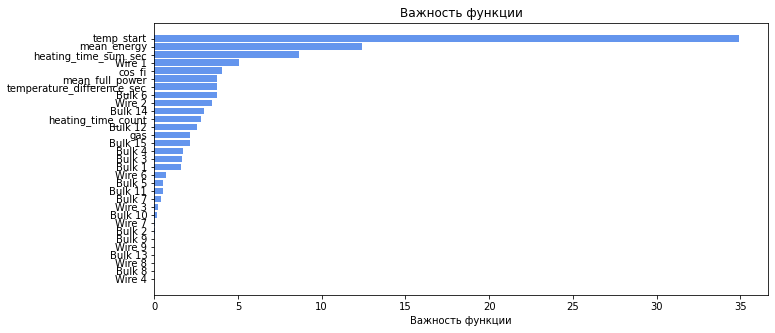

,Важность функции
temp_start,34.905416
mean_energy,12.424146
heating_time_sum_sec,8.635069
Wire 1,5.091322
cos_fi,4.027449
mean_full_power,3.761641
temperature_difference_sec,3.747065
Bulk 6,3.728402
Wire 2,3.462222
Bulk 14,2.983113


In [82]:
importances(model_cat,f_test)

**Попробуем побороться с мультиколлинеарностью признаков при помощи PCA**. (Чтобы было легче интерпретировать полученный результат заказчику, то будем выделять по 1 компоненте на группы высоко коррелирующих признаков, тогда сможем рассматривать полученные фичи как совокупность старых)

In [83]:
pca = PCA(n_components = 1)
eppca = pca.fit_transform(tmp[['mean_energy', 'mean_full_power', 'heating_time_sum_sec',]])
wbpca = pca.fit_transform(tmp[['Wire 4', 'Bulk 2', 'Bulk 7', 'Bulk 11', 'Bulk 12',]])

In [84]:
tmp.drop(columns=[
                  'heating_time_sum_sec',
                  'mean_energy',
                  'mean_full_power',
                  'heating_time_count',
                  'Wire 4',
                  'Bulk 2',
                  'Bulk 7',
                  'Wire 8',
                  'Bulk 11', 
                  'Bulk 12',
                 ], 
         inplace=True)

In [85]:
tmp['ep_comp'] = eppca
tmp['wb_comp'] = wbpca

### Проверка

In [86]:
f = tmp.drop(columns='end_temp')
t = tmp['end_temp']
f_train, f_test, t_train, t_test = train_test_split(f, t, test_size=0.2, random_state=RND, shuffle=True)

train_sample=f_train.shape[0]/f.shape[0]
test_sample=f_test.shape[0]/f.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 80%
Размер тестовой выборки - 20%


In [87]:
%%time

model_cat = CatBoostRegressor(loss_function="MAE", verbose=100, iterations=10000)
model_cat.fit(f_train,t_train, eval_set=(f_test,t_test), plot=True)
predict_cat=model_cat.predict(f_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.9028562	test: 8.1693982	best: 8.1693982 (0)	total: 4.03ms	remaining: 40.3s
100:	learn: 4.5209173	test: 4.9954784	best: 4.9954784 (100)	total: 269ms	remaining: 26.3s
200:	learn: 3.7712019	test: 4.5582281	best: 4.5582281 (200)	total: 510ms	remaining: 24.9s
300:	learn: 3.3902345	test: 4.4302640	best: 4.4302640 (300)	total: 741ms	remaining: 23.9s
400:	learn: 3.1197798	test: 4.3565879	best: 4.3565879 (400)	total: 993ms	remaining: 23.8s
500:	learn: 2.9136384	test: 4.3350102	best: 4.3340836 (482)	total: 1.25s	remaining: 23.8s
600:	learn: 2.7551256	test: 4.3284052	best: 4.3274125 (569)	total: 1.49s	remaining: 23.4s
700:	learn: 2.6434212	test: 4.3207128	best: 4.3203460 (698)	total: 1.72s	remaining: 22.9s
800:	learn: 2.5450149	test: 4.3108871	best: 4.3104400 (787)	total: 1.97s	remaining: 22.7s
900:	learn: 2.4631879	test: 4.3105349	best: 4.3091313 (821)	total: 2.21s	remaining: 22.3s
1000:	learn: 2.3867714	test: 4.3051324	best: 4.3047986 (998)	total: 2.45s	remaining: 22s
1100:	learn: 2

9000:	learn: 1.3206423	test: 4.2705554	best: 4.2606097 (6955)	total: 24.4s	remaining: 2.71s
9100:	learn: 1.3163720	test: 4.2694636	best: 4.2606097 (6955)	total: 24.6s	remaining: 2.43s
9200:	learn: 1.3110059	test: 4.2706491	best: 4.2606097 (6955)	total: 24.9s	remaining: 2.16s
9300:	learn: 1.3070266	test: 4.2714516	best: 4.2606097 (6955)	total: 25.1s	remaining: 1.89s
9400:	learn: 1.3034859	test: 4.2716130	best: 4.2606097 (6955)	total: 25.4s	remaining: 1.62s
9500:	learn: 1.3001441	test: 4.2712834	best: 4.2606097 (6955)	total: 25.6s	remaining: 1.34s
9600:	learn: 1.2963283	test: 4.2708875	best: 4.2606097 (6955)	total: 25.8s	remaining: 1.07s
9700:	learn: 1.2918355	test: 4.2693173	best: 4.2606097 (6955)	total: 26.3s	remaining: 810ms
9800:	learn: 1.2878465	test: 4.2695691	best: 4.2606097 (6955)	total: 26.5s	remaining: 538ms
9900:	learn: 1.2840515	test: 4.2700564	best: 4.2606097 (6955)	total: 26.7s	remaining: 267ms
9999:	learn: 1.2798995	test: 4.2690553	best: 4.2606097 (6955)	total: 27s	remaini

Пробовал тренировать через `grid_search`, но никак не удавалось приблизиться/улучшить качество модели, поэтому решил добавить кол-во итераций, чтобы немного улучшить результат.

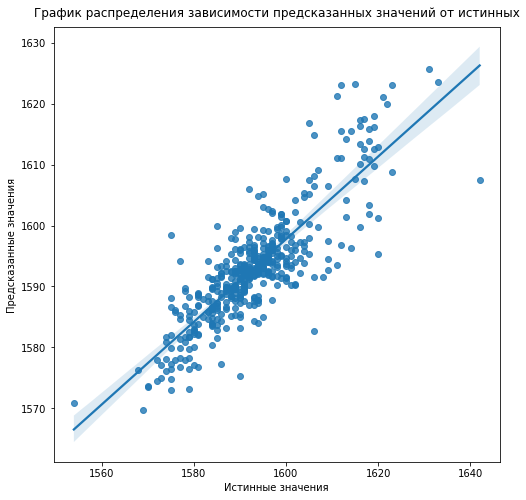

MAE модели CatBoostRegressor : 4.26
RMSE модели CatBoostRegressor : 6.05


In [88]:
res_cat = graph('CatBoostRegressor',predict_cat)

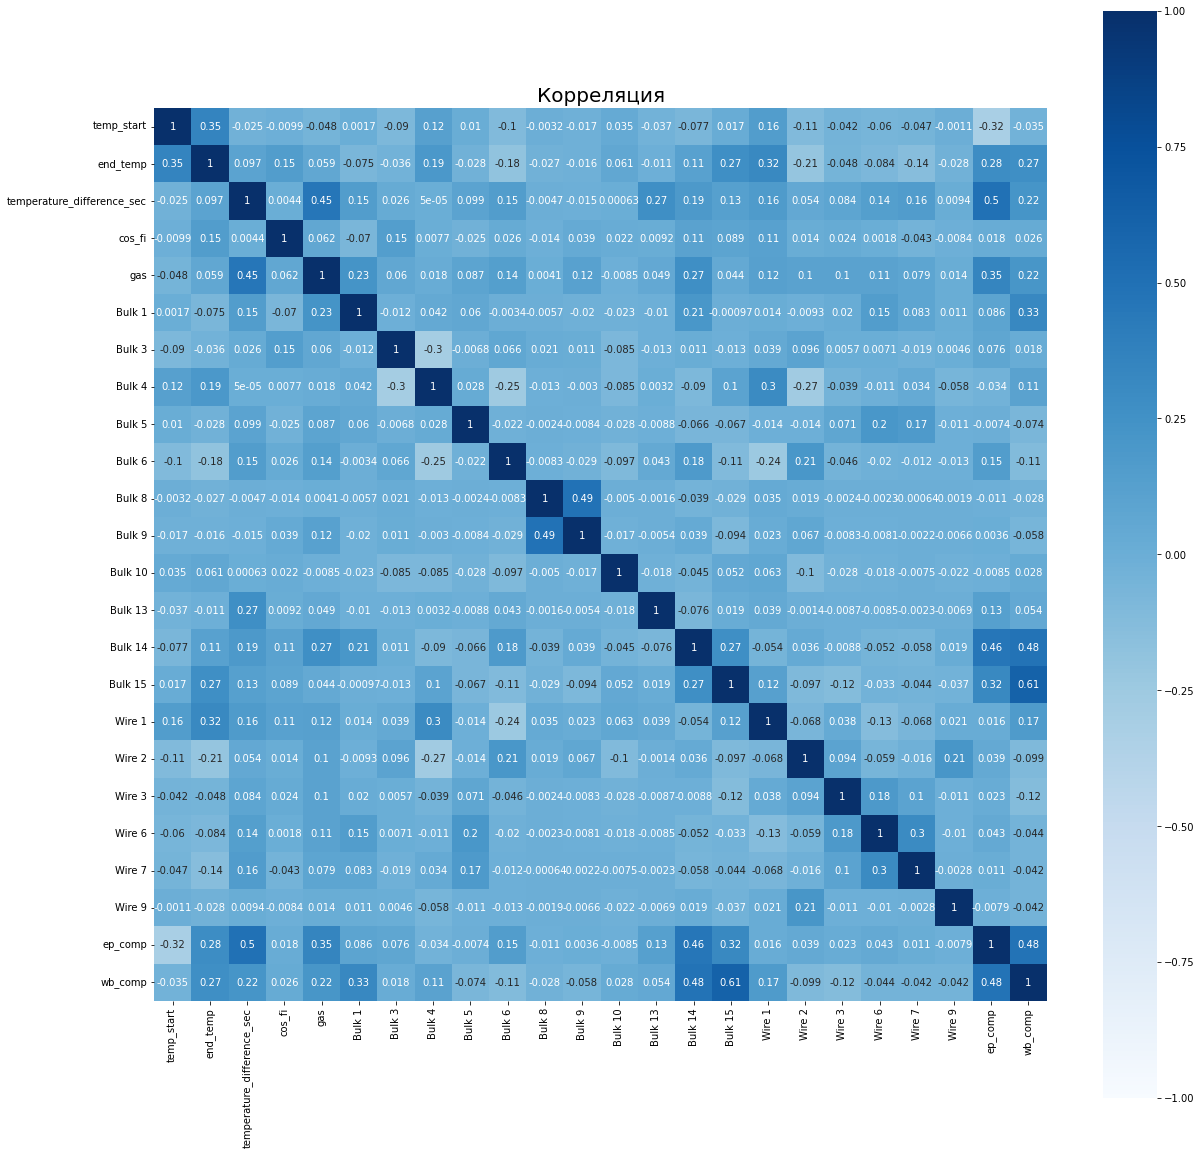

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

sns.heatmap(tmp.corr(), annot=True, square=True, vmin=-1, vmax=1, cmap="Blues", ax=ax)
plt.title('Корреляция', size=20)
plt.show()

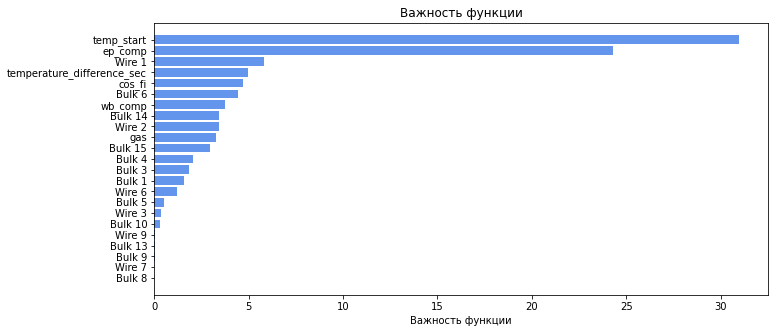

,Важность функции
temp_start,30.960000
ep_comp,24.323483
Wire 1,5.824004
temperature_difference_sec,4.949624
cos_fi,4.720944
Bulk 6,4.451301
wb_comp,3.738615
Bulk 14,3.454596
Wire 2,3.440533
gas,3.266379


In [90]:
importances(model_cat,f_test)

### Вывод

Мы использовали обработанные данные и обучили пять моделей `DecisionTreeRegressor`, `RandomForest`, `SimpleBoostReg`, `LGBMRegressor`, `CatBoostRegressor`.

По итогам сравнения метрик качества предсказаний из пяти моделей лидировал `CatBoostRegressor`, который достиг значений в $4.26$ по метрике $MAE$. Этот результат показывает, что модель в среднем ошибается на $4$ градуса температуры.

После исследования факторов важности наилучшей модели, мы смогли поработать с коррелирующими признаками без ущерба точности по $MAE$.

Таким образом, мы выполнили задачу и достигли требуемого значения $MAE < 6.00$, дополнительно выяснили наиболее важные данные на которых строились предсказания нашей наилучшей модели:

ТОП-3
1. temp_start
2. ep_comp
3. Wire 1

**Пути для дальнейшего развития:**
* В процессе EDA (а именно п2. Подготовка фрейма для обучения) были обнаруженны проблемы при замере входной и выходной температуры, при устранении этих неточностей возрастет качество полученной модели => сможем лучше оптимизировать производственные расходы.

* В процессе EDA (а именно п2. Подготовка фрейма для обучения) были также обнаруженны проблемы с детекцией подачи материалов/проволки или продувкой газом (Возможно произошел сбой при выгрузке, необходимо проверить со стороны заказчика), при устранении этих неточностей также возрастет качество модели => сможем еще лучше оптимизировать производственные расходы.

# Отчет по решению

Перед нами стояла задача оптимизировать производственные расходы, на этапе обработки стали. Для этого нам предстояло построить модель, которая предскажет температуру стали в последней точке измерения (целевой признак) имея данные об электродах, о подаче сыпучих материалов (объём и время), о продувке сплава газом, результаты измерения температуры и данные о проволочных материалах (объём и время). Целью поставлена метрика $MAE<6.00$

В ходе проделанной работы были выполнены все этапы плана: предобработка данных, исследовательский анализ данных, обучение и выбор моделей.


1. Подготовка и первый взгляд на данные:
* Чистка сета: 
    - Убрали партию с аномальным значением реактивной мощности;
    - Отказались от партий в которых отсутствовали значения по конечным температурным показаниям по партии (так как грамотно заменить эти "пропуски" просто невозможно).
* Обнаруженны пропуски во входных данных, а именно в данных о подаче сыпучих/проволочных материалов их мы заменили нулями (связанно со спецификой технологического процесса, объясняется это тем, что в каждую партию добавляют определенное количество материалов);
* Выделение новых факторов для дальнейшего объединения в финальную таблицу;
* Перевели форматы даты в datetime.

2. Подготовка фрейма для обучения:
* Обнаруженны проблемы при замере входной и выходной температуры, были также обнаруженны проблемы с детекцией подачи материалов/проволки или продувкой газом;
* Разобрались с пропущенными значениями и аномалиями, все необходимые признаки собрали в финальную таблицу;
* В финальный датафрейм была включена следующая информация:
    * temp_start - Начало нагрева;
    * end_temp - Завершение нагрева;
    * temperature_difference_sec - Разница между началом и завершением нагрева в секундах;
    * mean_full_power - Средняя полная мощность по партии;
    * heating_time_sum_sec - Общее время нагрева электродов по партии;
    * heating_time_count - Общее кол-во включений электродов;
    * cos_fi - Косинус угла сдвига фаз (коэффициентом мощности);
    * mean_energy - Средняя W (энергия) по партии;
    * gas - Данные о продувке сплава газом;
    * Bulk - данные о подаче сыпучих материалов (объём);
    * Wire - данные о проволочных материалах (объём).
* В ходе проверки финального датафрейма обнаружена мультиколинеарность факторов, было принято решение о пробном прогоне датафрейма на этапе обучения(следующий этап).

3. Обучение моделей:
* Мы использовали обработанные данные и обучили пять моделей `DecisionTreeRegressor`, `RandomForest`, `SimpleBoostReg`, `LGBMRegressor`, `CatBoostRegressor`:

| 	                  |MAE      |RMSE    |
| -------------       |:-------:| ------:|
|DecisionTreeRegressor|	5.547318|7.760808|
|RandomForest         | 4.599356|6.303007|
|Бустинг на пеньках   |	4.595859| 6.32627|
|LGBMRegressor        | 4.610919|6.354368|
|CatBoostRegressor    | 4.262444|5.986048|


* По итогам сравнения метрик качества предсказаний из пяти моделей лидировал `CatBoostRegressor`, который достиг значений в $4.26$ по метрике $MAE$. Этот результат показывает, что модель в среднем ошибается на $4$ градуса температуры;
* После исследования факторов важности наилучшей модели, мы смогли поработать с коррелирующими признаками (использовали PCA) без ущерба точности по $MAE$.
* Наиболее важными данными на которых строились предсказания стали:
    * temp_start
    * ep_comp
    * Wire 1
   
   